# Imports

In [1]:
import torch
import sys
# import functools
print(sys.executable)
import tensorflow as tf
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import resnet50
from PIL import Image
import torch.nn.functional as F
from torchvision.transforms import InterpolationMode

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingLR
# from torch.optim import lr_scheduler
# import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
# from FinalModels.ESRGAN.model import ESRGAN
from sklearn.utils.class_weight import compute_class_weight

project_root = os.path.abspath(os.path.join(os.getcwd()))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

folder_path = "d:\\workspace\\ThesisProject\\TESTS\\images\\LR"

print("Current device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")
print(f"Using device: {torch.device("cuda" if torch.cuda.is_available() else "cpu")}")

# esrgan_model = ESRGAN(model_path='./FinalModels/ESRGAN/model/RRDB_ESRGAN_x4.pth', device=device)


#TENSOR
# from tensorflow.keras.applications.resnet50 import preprocess_input
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate, Dense, Dropout, Activation, Conv2D, BatchNormalization
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
# from tensorflow.keras.optimizers import Adamax, Adam
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.models import load_model




d:\workspace\ThesisProject\venv\Scripts\python.exe
Current device: NVIDIA GeForce GTX 1050 Ti
Using device: cuda


# FUNCTIONS

In [2]:


def train_and_validate(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=5):
    history = {
        "epoch": [],
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }

    # scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        # lr = optimizer.param_groups[0]['lr']

        print(f"=====================================Epoch: {epoch + 1} / {num_epochs}=====================================")
        train_progress = tqdm(train_loader, total=len(train_loader), leave=True)

        for images, labels in train_progress:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            train_progress.set_description(f'[TRAIN] ')
            
        train_loss /= len(train_loader.dataset)
        train_acc = correct / total

        # Validation Phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0

        val_progress = tqdm(val_loader, total=len(val_loader), leave=True)
        with torch.no_grad():
            for inputs, labels in val_progress:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0) # 1

                probs = F.softmax(outputs, dim=1) # 3
                _, predicted = torch.max(probs, 1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

                val_progress.set_description(f'[VALID] ')

        val_loss /= len(val_loader.dataset) # 2
        val_acc = correct / total

        print(f'=> Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f} |  Train Acc={train_acc:.4f},  Val Acc={val_acc:.4f}')

        history["epoch"].append(epoch + 1)
        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)

        # scheduler.step()

    
    return history

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)


def pad_to_square(image):
    # Get original dimensions
    old_h, old_w = image.shape[:2]
    
    # Find the larger dimension to make the image square
    max_dim = max(old_h, old_w)
    
    # Calculate padding
    pad_h = (max_dim - old_h) // 2
    pad_w = (max_dim - old_w) // 2
    
    # Ensure padding is non-negative and compatible
    padded_image = tf.image.pad_to_bounding_box(image, pad_h, pad_w, max_dim, max_dim)
    
    # Handle any excess due to rounding differences
    padded_image = tf.image.resize_with_crop_or_pad(padded_image, max_dim, max_dim)
    
    return padded_image

def get_image_index(file_name, image_dir="./data/DATASET/TRAIN_UNET/enhanced_images/*.jpg"):
    """
    Retrieves the index of an image file name in the list of loaded images.
    
    Args:
        file_name (str): The file name of the image (e.g., 'image1.jpg').
        image_dir (str): The directory path of the images.

    Returns:
        int: The index of the image in the list of images, or -1 if not found.
    """
    for idx, img_path in enumerate(glob.glob(image_dir)):
        if file_name in img_path:
            return idx
    return -1

def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

def plot_image_tensor(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

# Training and evaluation loop for RESNET
def train_model(model, dataloader, val_dataloader, optimizer, criterion, epochs, device):
    # Initialize lists to store metrics for each epoch
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Create a tqdm progress bar for the dataloader
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}", ncols=100, unit="batch")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Update progress bar with loss and accuracy
            progress_bar.set_postfix(loss=running_loss/total, accuracy=correct/total)

        # Calculate training accuracy
        # scheduler.step()

        train_loss = running_loss / len(dataloader)
        train_acc = correct / total

        # Evaluate on the validation set
        val_acc, val_loss = evaluate_model(model, val_dataloader, criterion)

        # Save metrics for this epoch
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # , Learning Rate: {scheduler.get_last_lr()[0]:.6f}
        print(f"Epoch {epoch + 1}/{epochs}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    # Return the history for further processing (such as saving or plotting)
    history = {
        'epoch': range(1, epochs + 1),
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies
    }

    return history  # Return the history dictionary


# Evaluation loop for RESNET
def evaluate_model(model, dataloader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    return val_acc, val_loss / len(dataloader)

def test_model(model, test_dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred

def predict_image(model, image_path, device, class_labels):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match model input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as per ResNet's requirements
    ])
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Move the image to the same device as the model
    image = image.to(device)

    # Start time for inference
    start_time = time.time()

    # Perform inference
    model.eval()
    with torch.no_grad():
        outputs = model(image)

    # Calculate prediction probabilities using softmax
    probabilities = torch.nn.functional.softmax(outputs, dim=1)

    # Get the predicted class and its probability
    predicted_class_index = probabilities.argmax().item()
    predicted_class = class_labels[predicted_class_index]
    prediction_time = time.time() - start_time

    return predicted_class, prediction_time, probabilities[0]  # Return class, time, and probabilities

def predict_image_with_debug(model, image_path, device, class_labels):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0).to(device)
    # image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Convert tensor to NumPy array (H, W, C)
    # image = (image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # De-normalize
    # image = (image * 255).astype(np.uint8)  # Convert to 8-bit image

    # Start time for inference
    start_time = time.time()

    # Perform inference
    model.eval()
    with torch.no_grad():
        logits = model(image)  # Raw logits from the model

    # Calculate probabilities using softmax
    probabilities = torch.nn.functional.softmax(logits, dim=1)

    # Plot class probabilities
    plt.bar(range(len(class_labels)), probabilities[0].cpu().numpy())
    plt.xticks(range(len(class_labels)), class_labels, rotation=90)
    plt.show()

    # Get predicted class and its probability
    predicted_class_index = probabilities.argmax().item()
    predicted_class = class_labels[predicted_class_index]
    confidence = probabilities.max().item()
    prediction_time = time.time() - start_time

    return predicted_class, confidence, prediction_time


def plot_from_history(history, max_epochs):
    # Extract data from the history dictionary
    if isinstance(history['epoch'], range):
        # 'epoch' is a column in the DataFrame
        epochs = list(history['epoch'])[:max_epochs]
        train_losses = history['train_loss'][:max_epochs]
        val_losses = history['val_loss'][:max_epochs]
        train_accuracies = history['train_accuracy'][:max_epochs]
        val_accuracies = history['val_accuracy'][:max_epochs]

    elif isinstance(history['epoch'], list):
        # 'epoch' is a list
        epochs = history['epoch'][:max_epochs]
        train_losses = history['train_loss'][:max_epochs]
        val_losses = history['val_loss'][:max_epochs]
        train_accuracies = history['train_accuracy'][:max_epochs]
        val_accuracies = history['val_accuracy'][:max_epochs]
    else:
        # 'epoch' is a range object
        history_filtered = history[history['epoch'] <= max_epochs]
        epochs = history_filtered['epoch']
        train_losses = history_filtered['train_loss']
        val_losses = history_filtered['val_loss']
        train_accuracies = history_filtered['train_accuracy']
        val_accuracies = history_filtered['val_accuracy']

    # Plot the metrics
    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)  # Add grid

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='red', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)  # Add grid

    # Save the plot
    plt.tight_layout()
    plt.show()

def get_class_labels(dataset_dir):
    # Get all folder names in the directory, which are your class labels
    class_labels = sorted(os.listdir(dataset_dir))  # Assuming each subfolder is a class
    return class_labels

def save_model(model, history, model_path, history_path):
    # Save the model state dict
    torch.save(model, model_path)

    save_history_to_csv(history, history_path)

    print(f"Model saved to {model_path}")
    print(f"History saved to {history_path}")

def save_history_to_csv(history, filename):
    df = pd.DataFrame(history)
    df.to_csv(filename, index=False)
    print(f"History saved to {filename}")

def load_entire_model(model_path, device):
    # Load the entire model
    model = torch.load(model_path, weights_only=False)
    model.to(device)  # Ensure the model is on the correct device (CPU or GPU)
    print(f"Model loaded from {model_path}")
    
    return model

def load_history_from_csv(filename):
    df = pd.read_csv(filename)
    return df



# Dataset Preparation

In [9]:
train_dir = './DATASET/TRAIN'
enhancedtrain_dir = './DATASET/TRAIN_ESRGAN_UNET - ESRGAN'
test_dir = './DATASET/TEST - mergedval'
enhancedtest_dir = './DATASET/TEST_ESRGAN_UNET - ESRGAN-mergedval'
val_dir = './DATASET/VALIDATION'
enhancedval_dir = './DATASET/VALIDATION_ESRGAN_UNET - ESRGAN'

# train_dir = './DATASET/TRAIN'
# enhancedtrain_dir = './DATASET/TRAIN_ESRGAN2_UNET - ESRGAN'
# test_dir = './DATASET/TEST - mergedval'
# enhancedtest_dir = './DATASET/TEST_ESRGAN2_UNET - mergedval'
# val_dir = './DATASET/VALIDATION'
# enhancedval_dir = './DATASET/VALIDATION_ESRGAN2_UNET - ESRGAN'

# train_dir = './DATASET/TRAIN'
# enhancedtrain_dir = './DATASET/TRAIN_ESRGAN'
# test_dir = './DATASET/TEST'
# enhancedtest_dir = './DATASET/TEST_ESRGAN'
# val_dir = './DATASET/VALIDATION'
# enhancedval_dir = './DATASET/VALIDATION_ESRGAN'

# train_dir = './DATASET/TRAIN'
# enhancedtrain_dir = './DATASET/TRAIN_ESRGAN2_UNET - ESRGAN'
# test_dir = './DATASET/TEST - mergedval'
# enhancedtest_dir = './DATASET/TEST_ESRGAN2_UNET - mergedval'
# val_dir = './DATASET/VALIDATION'
# enhancedval_dir = './DATASET/VALIDATION_ESRGAN2_UNET - ESRGAN'

# train_dir = './DATASET/TRAIN'
# enhancedtrain_dir = './DATASET/TRAIN_ESRGAN2_UNET - ESRGAN'
# test_dir = './DATASET/TEST'
# enhancedtest_dir = './DATASET/TEST_ESRGAN2_UNET - ESRGAN'
# val_dir = './DATASET/VALIDATION'
# enhancedval_dir = './DATASET/VALIDATION_ESRGAN2_UNET - ESRGAN'

seed = 42
# np.random.seed(seed)
# random.seed(seed)


In [10]:
import random

random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

**FOR TENSORFLOW**

In [ ]:



img_height, img_width = 224, 224
batch_size = 64


tf.random.set_seed(seed)

train_datagen = ImageDataGenerator(
                                preprocessing_function=preprocess_input,
                                   )

enhancedtrain_datagen = ImageDataGenerator(
                                   preprocessing_function=preprocess_input,
                                   )



test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


enhancedval_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
enhancedtest_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),  
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=seed
)


validation_generator = validation_datagen.flow_from_directory(
    val_dir,  
    target_size=(img_height, img_width),  
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),  
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

enhancedtrain_generator = enhancedtrain_datagen.flow_from_directory(
    enhancedtrain_dir,
    target_size=(img_height, img_width),  
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=seed
)

enhancedvalidation_generator = enhancedval_datagen.flow_from_directory(
    enhancedval_dir,  
    target_size=(img_height, img_width),  
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  
)

enhancedtest_generator = enhancedtest_datagen.flow_from_directory(
    enhancedtest_dir,  
    target_size=(img_height, img_width),  
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  
)

**PYTORCH**

In [11]:


# Hyperparameters


img_height, img_width = 224, 224
batch_size = 16 #change to finetune

torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Data augmentation and normalization for training
augmented_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    # transforms.RandomRotation(90),
    transforms.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomResizedCrop((img_height, img_width), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


unaugmented_transform = transforms.Compose([
    transforms.Resize((img_height, img_width), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=unaugmented_transform) 
val_dataset = datasets.ImageFolder(val_dir, transform=unaugmented_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=unaugmented_transform)

# Enhanced datasets
enhanced_train_dataset = datasets.ImageFolder(enhancedtrain_dir, transform=unaugmented_transform)
enhanced_val_dataset = datasets.ImageFolder(enhancedval_dir, transform=unaugmented_transform)
enhanced_test_dataset = datasets.ImageFolder(enhancedtest_dir, transform=unaugmented_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

enhanced_train_loader = DataLoader(enhanced_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
enhanced_val_loader = DataLoader(enhanced_val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
enhanced_test_loader = DataLoader(enhanced_test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


class_counts = np.bincount(train_dataset.targets)
num_classes = len(class_counts)

class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(num_classes), y=train_dataset.targets)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class Weights:", class_weights)
print(f"Number of images in training set: {len(train_dataset)}")
print(f"Number of images in validation set: {len(val_dataset)}")
print(f"Number of images in test set: {len(test_dataset)}")

print(f"Number of images in enhanced training set: {len(enhanced_train_dataset)}")
print(f"Number of images in enhanced validation set: {len(enhanced_val_dataset)}")
print(f"Number of images in enhanced test set: {len(enhanced_test_dataset)}")

# Get file paths from train and validation datasets
train_files = set([sample[0] for sample in train_dataset.samples])
val_files = set([sample[0] for sample in val_dataset.samples])

# Find overlapping images
overlapping_files = train_files.intersection(val_files)

# Check if there's any overlap
if overlapping_files:
    print(f"{len(overlapping_files)} duplicate images found between train and validation sets.")
    print("Examples:", list(overlapping_files)[:5])  # Show first 5 duplicate file paths
else:
    print("✅ No duplicate images found between train and validation sets.")



Class Weights: tensor([1.3717, 0.6057, 3.3313, 0.8969, 0.7013, 0.5519, 3.2165, 0.6433, 0.2961,
        9.3278, 0.4421, 4.6639, 0.7345, 2.3917, 2.7435, 5.4869, 6.6627, 1.5045],
       device='cuda:0')
Number of images in training set: 1679
Number of images in validation set: 474
Number of images in test set: 720
Number of images in enhanced training set: 1679
Number of images in enhanced validation set: 474
Number of images in enhanced test set: 720
✅ No duplicate images found between train and validation sets.


# BASELINE (TENSORFLOW)

In [ ]:
baseline_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#143 LAYERS ORIGINAL
for layer in baseline_model.layers:  
    layer.trainable = False


for i, layer in enumerate(baseline_model.layers):
   print(i, layer.name, layer.trainable)

0 input_layer_5 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv

In [ ]:
x = baseline_model.output

x = GlobalAveragePooling2D()(x)

x = Activation('tanh')(x)

output_layer = Dense(18, activation="softmax", name='classification_output')(x)

# Final model
baseline_model = Model(inputs=baseline_model.input, outputs=output_layer, name="baseline_ResNet-50")



initial_lr = 0.001

optimizer = Adamax(learning_rate=initial_lr)

baseline_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# basemodel.summary()

In [ ]:
#HYPER PARAMETERS
#checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.00001)

baseline_history_tensor = baseline_model.fit(
    train_generator,
    validation_data = test_generator,
    epochs=5,
    validation_freq=1,
    verbose=1,
)


Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 111s 4s/step - accuracy: 0.3076 - loss: 2.4241 - val_accuracy: 0.6083 - val_loss: 1.4770
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.6877 - loss: 1.3279 - val_accuracy: 0.7111 - val_loss: 1.0872
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.7675 - loss: 0.9264 - val_accuracy: 0.7736 - val_loss: 0.8936
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - accuracy: 0.8174 - loss: 0.7589 - val_accuracy: 0.8042 - val_loss: 0.7707
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.8547 - loss: 0.6522 - val_accuracy: 0.8194 - val_loss: 0.6822


In [ ]:
y_pred = baseline_model.predict(test_generator)
y_pred_classes = y_pred.argmax(axis=1)

y_true = test_generator.classes


for i in range(10):  # Checking the first 10 predictions
    print(f"True Label: {y_true[i]}, Predicted Label: {y_pred_classes[i]}")

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

f1 = f1_score(y_true, y_pred_classes, average='weighted')
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_true, y_pred_classes)

print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')

In [ ]:
# Plot the Loss

plt.plot(baseline_history_tensor.history['loss'], label = 'train_loss')
plt.plot(baseline_history_tensor.history['val_loss'], label ='val loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')

# Plot the Accuracy
plt.plot(baseline_history_tensor.history['accuracy'], label = 'train accuracy')
plt.plot(baseline_history_tensor.history['val_accuracy'], label ='val accuracy')
plt.legend()
plt.show()
# plt.savefig('valAccuracy')


# BASELINE (PYTORCH)

In [20]:
learning_rate = 0.001
epochs = 30


torch_baseline = resnet50(weights="IMAGENET1K_V1")
torch_baseline = torch_baseline.to(device)

# Freeze the initial 39 layers
# freeze = True
# for name, layer in torch_baseline.named_modules():
#     # Explicitly freeze all layers up to layer3
#     if 'layer4' in name:
#         freeze = False  # Start unfreezing at layer3
#     if freeze:
#         for param in layer.parameters():
#             param.requires_grad = False
#     else:
#         for param in layer.parameters():
#             param.requires_grad = True

# FREEZE ALL LAYERS
for param in torch_baseline.parameters():
    param.requires_grad = False

for param in torch_baseline.fc.parameters():
    param.requires_grad = True

class BaselineResNet(nn.Module):
    def __init__(self, base_model, num_classes=18):
        super(BaselineResNet, self).__init__()
        self.base_model = nn.Sequential(*list(base_model.children())[:-2])  # Exclude top layers
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)  # 2048 (gap) + 2048 (gmp) = 4096

    def forward(self, x):
        x = self.base_model(x)
        gap = self.gap(x).view(x.size(0), -1)
        x = self.fc(gap)
        return x


torch_baseline_model = BaselineResNet(torch_baseline).to(device)


criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adamax(torch_baseline_model.parameters(), lr=learning_rate)



for name, layer in torch_baseline.named_modules():
    print(f'{name}: {any(param.requires_grad for param in layer.parameters())}')


: True
conv1: False
bn1: False
relu: False
maxpool: False
layer1: False
layer1.0: False
layer1.0.conv1: False
layer1.0.bn1: False
layer1.0.conv2: False
layer1.0.bn2: False
layer1.0.conv3: False
layer1.0.bn3: False
layer1.0.relu: False
layer1.0.downsample: False
layer1.0.downsample.0: False
layer1.0.downsample.1: False
layer1.1: False
layer1.1.conv1: False
layer1.1.bn1: False
layer1.1.conv2: False
layer1.1.bn2: False
layer1.1.conv3: False
layer1.1.bn3: False
layer1.1.relu: False
layer1.2: False
layer1.2.conv1: False
layer1.2.bn1: False
layer1.2.conv2: False
layer1.2.bn2: False
layer1.2.conv3: False
layer1.2.bn3: False
layer1.2.relu: False
layer2: False
layer2.0: False
layer2.0.conv1: False
layer2.0.bn1: False
layer2.0.conv2: False
layer2.0.bn2: False
layer2.0.conv3: False
layer2.0.bn3: False
layer2.0.relu: False
layer2.0.downsample: False
layer2.0.downsample.0: False
layer2.0.downsample.1: False
layer2.1: False
layer2.1.conv1: False
layer2.1.bn1: False
layer2.1.conv2: False
layer2.1.bn2

**TRAIN METHOD 1**

In [ ]:
baseline_history = train_model(torch_baseline_model, train_loader, val_loader, optimizer, criterion, epochs=epochs, device=device)

In [21]:
baseline_history = train_model(torch_baseline_model, enhanced_train_loader, enhanced_val_loader, optimizer, criterion, epochs=epochs, device=device)

Epoch 1/30: 100%|██████████████████| 105/105 [00:30<00:00,  3.46batch/s, accuracy=0.486, loss=0.149]


Epoch 1/30: Train Loss=2.3867, Train Acc=0.4860, Val Loss=1.6745, Val Acc=0.7384


Epoch 2/30: 100%|██████████████████| 105/105 [00:28<00:00,  3.69batch/s, accuracy=0.756, loss=0.102]


Epoch 2/30: Train Loss=1.6236, Train Acc=0.7564, Val Loss=1.2512, Val Acc=0.8165


Epoch 3/30: 100%|█████████████████| 105/105 [00:29<00:00,  3.56batch/s, accuracy=0.802, loss=0.0812]


Epoch 3/30: Train Loss=1.2991, Train Acc=0.8023, Val Loss=1.0201, Val Acc=0.8439


Epoch 4/30: 100%|█████████████████| 105/105 [00:27<00:00,  3.76batch/s, accuracy=0.841, loss=0.0673]


Epoch 4/30: Train Loss=1.0757, Train Acc=0.8410, Val Loss=0.8850, Val Acc=0.8544


Epoch 5/30: 100%|█████████████████| 105/105 [00:28<00:00,  3.71batch/s, accuracy=0.858, loss=0.0582]


Epoch 5/30: Train Loss=0.9310, Train Acc=0.8577, Val Loss=0.7929, Val Acc=0.8671


Epoch 6/30: 100%|██████████████████| 105/105 [00:29<00:00,  3.53batch/s, accuracy=0.87, loss=0.0514]


Epoch 6/30: Train Loss=0.8227, Train Acc=0.8702, Val Loss=0.7207, Val Acc=0.8840


Epoch 7/30: 100%|██████████████████| 105/105 [00:28<00:00,  3.64batch/s, accuracy=0.87, loss=0.0461]


Epoch 7/30: Train Loss=0.7378, Train Acc=0.8696, Val Loss=0.6522, Val Acc=0.8797


Epoch 8/30: 100%|█████████████████| 105/105 [00:28<00:00,  3.72batch/s, accuracy=0.891, loss=0.0419]


Epoch 8/30: Train Loss=0.6696, Train Acc=0.8910, Val Loss=0.5882, Val Acc=0.9008


Epoch 9/30: 100%|█████████████████| 105/105 [00:28<00:00,  3.72batch/s, accuracy=0.889, loss=0.0397]


Epoch 9/30: Train Loss=0.6351, Train Acc=0.8886, Val Loss=0.5571, Val Acc=0.9008


Epoch 10/30: 100%|█████████████████| 105/105 [00:30<00:00,  3.47batch/s, accuracy=0.904, loss=0.036]


Epoch 10/30: Train Loss=0.5755, Train Acc=0.9035, Val Loss=0.5453, Val Acc=0.9008


Epoch 11/30: 100%|████████████████| 105/105 [00:28<00:00,  3.64batch/s, accuracy=0.904, loss=0.0337]


Epoch 11/30: Train Loss=0.5383, Train Acc=0.9041, Val Loss=0.5527, Val Acc=0.8840


Epoch 12/30: 100%|████████████████| 105/105 [00:28<00:00,  3.72batch/s, accuracy=0.902, loss=0.0318]


Epoch 12/30: Train Loss=0.5080, Train Acc=0.9017, Val Loss=0.4666, Val Acc=0.9072


Epoch 13/30: 100%|████████████████| 105/105 [00:28<00:00,  3.69batch/s, accuracy=0.915, loss=0.0284]


Epoch 13/30: Train Loss=0.4541, Train Acc=0.9148, Val Loss=0.4517, Val Acc=0.9114


Epoch 14/30: 100%|████████████████| 105/105 [00:30<00:00,  3.48batch/s, accuracy=0.905, loss=0.0281]


Epoch 14/30: Train Loss=0.4501, Train Acc=0.9053, Val Loss=0.4500, Val Acc=0.9051


Epoch 15/30: 100%|████████████████| 105/105 [00:28<00:00,  3.70batch/s, accuracy=0.924, loss=0.0243]


Epoch 15/30: Train Loss=0.3890, Train Acc=0.9238, Val Loss=0.4270, Val Acc=0.9114


Epoch 16/30: 100%|████████████████| 105/105 [00:28<00:00,  3.74batch/s, accuracy=0.916, loss=0.0257]


Epoch 16/30: Train Loss=0.4111, Train Acc=0.9160, Val Loss=0.4291, Val Acc=0.9114


Epoch 17/30: 100%|████████████████| 105/105 [00:31<00:00,  3.39batch/s, accuracy=0.924, loss=0.0238]


Epoch 17/30: Train Loss=0.3803, Train Acc=0.9238, Val Loss=0.3849, Val Acc=0.9198


Epoch 18/30: 100%|█████████████████| 105/105 [00:30<00:00,  3.39batch/s, accuracy=0.916, loss=0.023]


Epoch 18/30: Train Loss=0.3678, Train Acc=0.9160, Val Loss=0.3771, Val Acc=0.9093


Epoch 19/30: 100%|████████████████| 105/105 [00:27<00:00,  3.79batch/s, accuracy=0.923, loss=0.0218]


Epoch 19/30: Train Loss=0.3482, Train Acc=0.9232, Val Loss=0.3597, Val Acc=0.9241


Epoch 20/30: 100%|████████████████| 105/105 [00:27<00:00,  3.81batch/s, accuracy=0.928, loss=0.0204]


Epoch 20/30: Train Loss=0.3257, Train Acc=0.9279, Val Loss=0.3653, Val Acc=0.9114


Epoch 21/30: 100%|████████████████| 105/105 [00:31<00:00,  3.37batch/s, accuracy=0.925, loss=0.0191]


Epoch 21/30: Train Loss=0.3061, Train Acc=0.9250, Val Loss=0.3429, Val Acc=0.9156


Epoch 22/30: 100%|████████████████| 105/105 [00:30<00:00,  3.39batch/s, accuracy=0.933, loss=0.0197]


Epoch 22/30: Train Loss=0.3153, Train Acc=0.9333, Val Loss=0.3438, Val Acc=0.9325


Epoch 23/30: 100%|████████████████| 105/105 [00:27<00:00,  3.84batch/s, accuracy=0.936, loss=0.0179]


Epoch 23/30: Train Loss=0.2855, Train Acc=0.9357, Val Loss=0.3439, Val Acc=0.9198


Epoch 24/30: 100%|████████████████| 105/105 [00:27<00:00,  3.83batch/s, accuracy=0.929, loss=0.0184]


Epoch 24/30: Train Loss=0.2940, Train Acc=0.9291, Val Loss=0.3478, Val Acc=0.9283


Epoch 25/30: 100%|████████████████| 105/105 [00:30<00:00,  3.42batch/s, accuracy=0.937, loss=0.0182]


Epoch 25/30: Train Loss=0.2909, Train Acc=0.9375, Val Loss=0.3166, Val Acc=0.9219


Epoch 26/30: 100%|█████████████████| 105/105 [00:27<00:00,  3.85batch/s, accuracy=0.94, loss=0.0159]


Epoch 26/30: Train Loss=0.2541, Train Acc=0.9398, Val Loss=0.3212, Val Acc=0.9241


Epoch 27/30: 100%|████████████████| 105/105 [00:27<00:00,  3.80batch/s, accuracy=0.939, loss=0.0152]


Epoch 27/30: Train Loss=0.2427, Train Acc=0.9387, Val Loss=0.3162, Val Acc=0.9241


Epoch 28/30: 100%|████████████████| 105/105 [00:30<00:00,  3.41batch/s, accuracy=0.944, loss=0.0155]


Epoch 28/30: Train Loss=0.2476, Train Acc=0.9440, Val Loss=0.2955, Val Acc=0.9346


Epoch 29/30: 100%|████████████████| 105/105 [00:31<00:00,  3.38batch/s, accuracy=0.949, loss=0.0148]


Epoch 29/30: Train Loss=0.2364, Train Acc=0.9488, Val Loss=0.2910, Val Acc=0.9241


Epoch 30/30: 100%|████████████████| 105/105 [00:27<00:00,  3.80batch/s, accuracy=0.943, loss=0.0148]


Epoch 30/30: Train Loss=0.2375, Train Acc=0.9428, Val Loss=0.2893, Val Acc=0.9219


**TRAIN METHOD 2**

In [87]:
# Train model
baseline_history = train_and_validate(torch_baseline_model, criterion, optimizer, train_loader, val_loader, device, num_epochs=epochs)

=====================================Epoch: 1 / 10=====================================


[VALID] : 100%|██████████| 30/30 [00:15<00:00,  1.97it/s]


=> Train Loss=2.4332, Val Loss=1.6478 |  Train Acc=0.4943,  Val Acc=0.7700
=====================================Epoch: 2 / 10=====================================


[VALID] : 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]


=> Train Loss=1.6470, Val Loss=1.2303 |  Train Acc=0.7641,  Val Acc=0.8165
=====================================Epoch: 3 / 10=====================================


[VALID] : 100%|██████████| 30/30 [00:13<00:00,  2.17it/s]


=> Train Loss=1.3189, Val Loss=0.9680 |  Train Acc=0.8160,  Val Acc=0.8523
=====================================Epoch: 4 / 10=====================================


[VALID] : 100%|██████████| 30/30 [00:14<00:00,  2.09it/s]


=> Train Loss=1.1094, Val Loss=0.8213 |  Train Acc=0.8541,  Val Acc=0.8713
=====================================Epoch: 5 / 10=====================================


[VALID] : 100%|██████████| 30/30 [00:14<00:00,  2.01it/s]


=> Train Loss=0.9364, Val Loss=0.7470 |  Train Acc=0.8851,  Val Acc=0.8840
=====================================Epoch: 6 / 10=====================================


[VALID] : 100%|██████████| 30/30 [00:14<00:00,  2.07it/s]


=> Train Loss=0.8225, Val Loss=0.7014 |  Train Acc=0.8833,  Val Acc=0.8523
=====================================Epoch: 7 / 10=====================================


[VALID] : 100%|██████████| 30/30 [00:14<00:00,  2.08it/s]


=> Train Loss=0.7210, Val Loss=0.5728 |  Train Acc=0.8916,  Val Acc=0.9030
=====================================Epoch: 8 / 10=====================================


[VALID] : 100%|██████████| 30/30 [00:14<00:00,  2.03it/s]


=> Train Loss=0.6408, Val Loss=0.5496 |  Train Acc=0.9023,  Val Acc=0.9093
=====================================Epoch: 9 / 10=====================================


[VALID] : 100%|██████████| 30/30 [00:14<00:00,  2.09it/s]


=> Train Loss=0.5738, Val Loss=0.5261 |  Train Acc=0.9089,  Val Acc=0.9008
=====================================Epoch: 10 / 10=====================================


[VALID] : 100%|██████████| 30/30 [00:19<00:00,  1.53it/s]

=> Train Loss=0.5418, Val Loss=0.5016 |  Train Acc=0.9119,  Val Acc=0.9030


In [84]:
# Train model
baseline_history = train_and_validate(torch_baseline_model, criterion, optimizer, enhanced_train_loader, enhanced_val_loader, device, num_epochs=epochs)

=====================================Epoch: 1 / 10=====================================


[VALID] : 100%|██████████| 30/30 [00:14<00:00,  2.06it/s]


=> Train Loss=2.3682, Val Loss=1.6307 |  Train Acc=0.4860,  Val Acc=0.6878
=====================================Epoch: 2 / 10=====================================


[VALID] : 100%|██████████| 30/30 [00:15<00:00,  1.95it/s]


=> Train Loss=1.6011, Val Loss=1.2192 |  Train Acc=0.7362,  Val Acc=0.8017
=====================================Epoch: 3 / 10=====================================


[VALID] : 100%|██████████| 30/30 [00:14<00:00,  2.00it/s]


=> Train Loss=1.3199, Val Loss=1.0691 |  Train Acc=0.8029,  Val Acc=0.8122
=====================================Epoch: 4 / 10=====================================


[VALID] : 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


=> Train Loss=1.0850, Val Loss=0.9100 |  Train Acc=0.8362,  Val Acc=0.8608
=====================================Epoch: 5 / 10=====================================


[VALID] : 100%|██████████| 30/30 [00:15<00:00,  1.95it/s]


=> Train Loss=0.9383, Val Loss=0.8158 |  Train Acc=0.8517,  Val Acc=0.8755
=====================================Epoch: 6 / 10=====================================


[VALID] : 100%|██████████| 30/30 [00:15<00:00,  1.99it/s]


=> Train Loss=0.8254, Val Loss=0.7895 |  Train Acc=0.8636,  Val Acc=0.8481
=====================================Epoch: 7 / 10=====================================


[VALID] : 100%|██████████| 30/30 [00:16<00:00,  1.82it/s]


=> Train Loss=0.7424, Val Loss=0.6763 |  Train Acc=0.8678,  Val Acc=0.8776
=====================================Epoch: 8 / 10=====================================


[VALID] : 100%|██████████| 30/30 [00:14<00:00,  2.00it/s]


=> Train Loss=0.7062, Val Loss=0.6063 |  Train Acc=0.8690,  Val Acc=0.8861
=====================================Epoch: 9 / 10=====================================


[VALID] : 100%|██████████| 30/30 [00:14<00:00,  2.04it/s]


=> Train Loss=0.6239, Val Loss=0.5521 |  Train Acc=0.8928,  Val Acc=0.8945
=====================================Epoch: 10 / 10=====================================


[VALID] : 100%|██████████| 30/30 [00:14<00:00,  2.00it/s]

=> Train Loss=0.5577, Val Loss=0.5522 |  Train Acc=0.8993,  Val Acc=0.8924


**LOAD MODEL (OPTIONAL)**

In [ ]:
torch_baseline_model = BaselineResNet(torch_baseline).to(device)

# Load the saved weights
torch_baseline_model.load_state_dict(torch.load("./saved_models/PREFINAL/weights/filename.pth", map_location=device))

# Set the model to evaluation mode
torch_baseline_model.eval()

# BASELINE 2 (PYTORCH)

In [79]:
from torchvision import models
# Model Definition
torch_baseline_model = models.resnet50(weights="IMAGENET1K_V1")

torch_baseline_model.fc = nn.Sequential(
    nn.Linear(2048, 18),  
)

# Freeze all layers
for param in torch_baseline_model.parameters():
    param.requires_grad = False

for param in torch_baseline_model.fc.parameters():
    param.requires_grad = True


torch_baseline_model = torch_baseline_model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(torch_baseline_model.parameters(), lr=0.001)

# for name, layer in baseline_model.named_modules():
#     print(f'{name}: {any(param.requires_grad for param in layer.parameters())}')
    


In [80]:

baseline_history = train_and_validate(torch_baseline_model, criterion, optimizer, train_loader, test_loader, device, num_epochs=10)

=====================================Epoch: 1 / 10=====================================


[VALID] : 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]


=> Train Loss=1.9012, Val Loss=1.3781 |  Train Acc=0.5205,  Val Acc=0.6707
=====================================Epoch: 2 / 10=====================================


[VALID] : 100%|██████████| 16/16 [00:07<00:00,  2.22it/s]


=> Train Loss=1.1871, Val Loss=0.9890 |  Train Acc=0.7207,  Val Acc=0.7398
=====================================Epoch: 3 / 10=====================================


[VALID] : 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]


=> Train Loss=0.8956, Val Loss=0.8261 |  Train Acc=0.7915,  Val Acc=0.7805
=====================================Epoch: 4 / 10=====================================


[VALID] : 100%|██████████| 16/16 [00:07<00:00,  2.27it/s]


=> Train Loss=0.7386, Val Loss=0.6861 |  Train Acc=0.8314,  Val Acc=0.8252
=====================================Epoch: 5 / 10=====================================


[VALID] : 100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


=> Train Loss=0.6306, Val Loss=0.6152 |  Train Acc=0.8612,  Val Acc=0.8293
=====================================Epoch: 6 / 10=====================================


[VALID] : 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]


=> Train Loss=0.5575, Val Loss=0.5371 |  Train Acc=0.8791,  Val Acc=0.8659
=====================================Epoch: 7 / 10=====================================


[VALID] : 100%|██████████| 16/16 [00:08<00:00,  1.89it/s]


=> Train Loss=0.4978, Val Loss=0.4992 |  Train Acc=0.8851,  Val Acc=0.8659
=====================================Epoch: 8 / 10=====================================


[VALID] : 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]


=> Train Loss=0.4660, Val Loss=0.4619 |  Train Acc=0.9017,  Val Acc=0.8902
=====================================Epoch: 9 / 10=====================================


[VALID] : 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]


=> Train Loss=0.4026, Val Loss=0.4267 |  Train Acc=0.9136,  Val Acc=0.8862
=====================================Epoch: 10 / 10=====================================


[VALID] : 100%|██████████| 16/16 [00:06<00:00,  2.29it/s]

=> Train Loss=0.3837, Val Loss=0.3965 |  Train Acc=0.9148,  Val Acc=0.9065


In [76]:

baseline_history = train_and_validate(torch_baseline_model, criterion, optimizer, enhanced_train_loader, enhanced_test_loader, device, num_epochs=10)

=====================================Epoch: 1 / 10=====================================


[VALID] : 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]


=> Train Loss=1.9252, Val Loss=1.4310 |  Train Acc=0.4961,  Val Acc=0.6585
=====================================Epoch: 2 / 10=====================================


[VALID] : 100%|██████████| 16/16 [00:07<00:00,  2.12it/s]


=> Train Loss=1.2165, Val Loss=1.0441 |  Train Acc=0.7082,  Val Acc=0.7195
=====================================Epoch: 3 / 10=====================================


[VALID] : 100%|██████████| 16/16 [00:07<00:00,  2.13it/s]


=> Train Loss=0.9500, Val Loss=0.8365 |  Train Acc=0.7618,  Val Acc=0.7886
=====================================Epoch: 4 / 10=====================================


[VALID] : 100%|██████████| 16/16 [00:07<00:00,  2.11it/s]


=> Train Loss=0.7984, Val Loss=0.7483 |  Train Acc=0.8076,  Val Acc=0.7927
=====================================Epoch: 5 / 10=====================================


[VALID] : 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]


=> Train Loss=0.6965, Val Loss=0.6366 |  Train Acc=0.8267,  Val Acc=0.8415
=====================================Epoch: 6 / 10=====================================


[VALID] : 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]


=> Train Loss=0.6191, Val Loss=0.5605 |  Train Acc=0.8374,  Val Acc=0.8821
=====================================Epoch: 7 / 10=====================================


[VALID] : 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]


=> Train Loss=0.5545, Val Loss=0.5551 |  Train Acc=0.8678,  Val Acc=0.8618
=====================================Epoch: 8 / 10=====================================


[VALID] : 100%|██████████| 16/16 [00:07<00:00,  2.20it/s]


=> Train Loss=0.4992, Val Loss=0.4872 |  Train Acc=0.8809,  Val Acc=0.8984
=====================================Epoch: 9 / 10=====================================


[VALID] : 100%|██████████| 16/16 [00:07<00:00,  2.01it/s]


=> Train Loss=0.4840, Val Loss=0.4536 |  Train Acc=0.8803,  Val Acc=0.8821
=====================================Epoch: 10 / 10=====================================


[VALID] : 100%|██████████| 16/16 [00:07<00:00,  2.22it/s]

=> Train Loss=0.4351, Val Loss=0.4297 |  Train Acc=0.9011,  Val Acc=0.8984


# TEST BASELINE

**CLASSIFICATION REPORT**

In [110]:

# ENAHCED
y_true, y_pred = test_model(torch_baseline_model, enhanced_test_loader)

print("\nClassification Report:")

class_names = train_dataset.classes

print(classification_report(y_true, y_pred, target_names=class_names))

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'\nF1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')



Classification Report:
                         precision    recall  f1-score   support

   Abudefduf Vaigiensis       0.81      0.87      0.84        30
 Acanthurus Nigrofuscus       0.90      0.86      0.88        64
   Balistapus Undulatus       0.80      0.92      0.86        13
 Canthigaster Valentini       0.91      0.95      0.93        43
 Chaetodon Trifascialis       0.94      0.81      0.87        57
   Hemigymnus Fasciatus       0.94      0.92      0.93        72
  Hemigymnus Melapterus       0.75      0.92      0.83        13
        Lutjanus fulvus       0.98      0.95      0.97        61
     Myripristis Kuntee       0.98      0.97      0.98       135
Neoglyphidodon Nigroris       0.60      0.50      0.55         6
      Neoniphon Sammara       0.99      1.00      0.99        88
 Pempheris Vanicolensis       1.00      1.00      1.00         9
Pomacentrus Moluccensis       1.00      1.00      1.00        54
               Scaridae       0.89      1.00      0.94        17


In [105]:

# NOT ENHANCED
y_true, y_pred = test_model(torch_baseline_model, test_loader)

print("\nClassification Report:")

class_names = train_dataset.classes

print(classification_report(y_true, y_pred, target_names=class_names))

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'\nF1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')



Classification Report:
                         precision    recall  f1-score   support

   Abudefduf Vaigiensis       0.88      0.93      0.90        30
 Acanthurus Nigrofuscus       0.89      0.84      0.86        64
   Balistapus Undulatus       0.92      0.85      0.88        13
 Canthigaster Valentini       0.91      1.00      0.96        43
 Chaetodon Trifascialis       0.91      0.89      0.90        57
   Hemigymnus Fasciatus       0.96      0.93      0.94        72
  Hemigymnus Melapterus       0.80      0.92      0.86        13
        Lutjanus fulvus       1.00      1.00      1.00        61
     Myripristis Kuntee       0.99      0.97      0.98       135
Neoglyphidodon Nigroris       1.00      0.83      0.91         6
      Neoniphon Sammara       0.99      0.99      0.99        88
 Pempheris Vanicolensis       0.90      1.00      0.95         9
Pomacentrus Moluccensis       1.00      0.96      0.98        54
               Scaridae       0.77      1.00      0.87        17


**CONFUSION MATRIX**

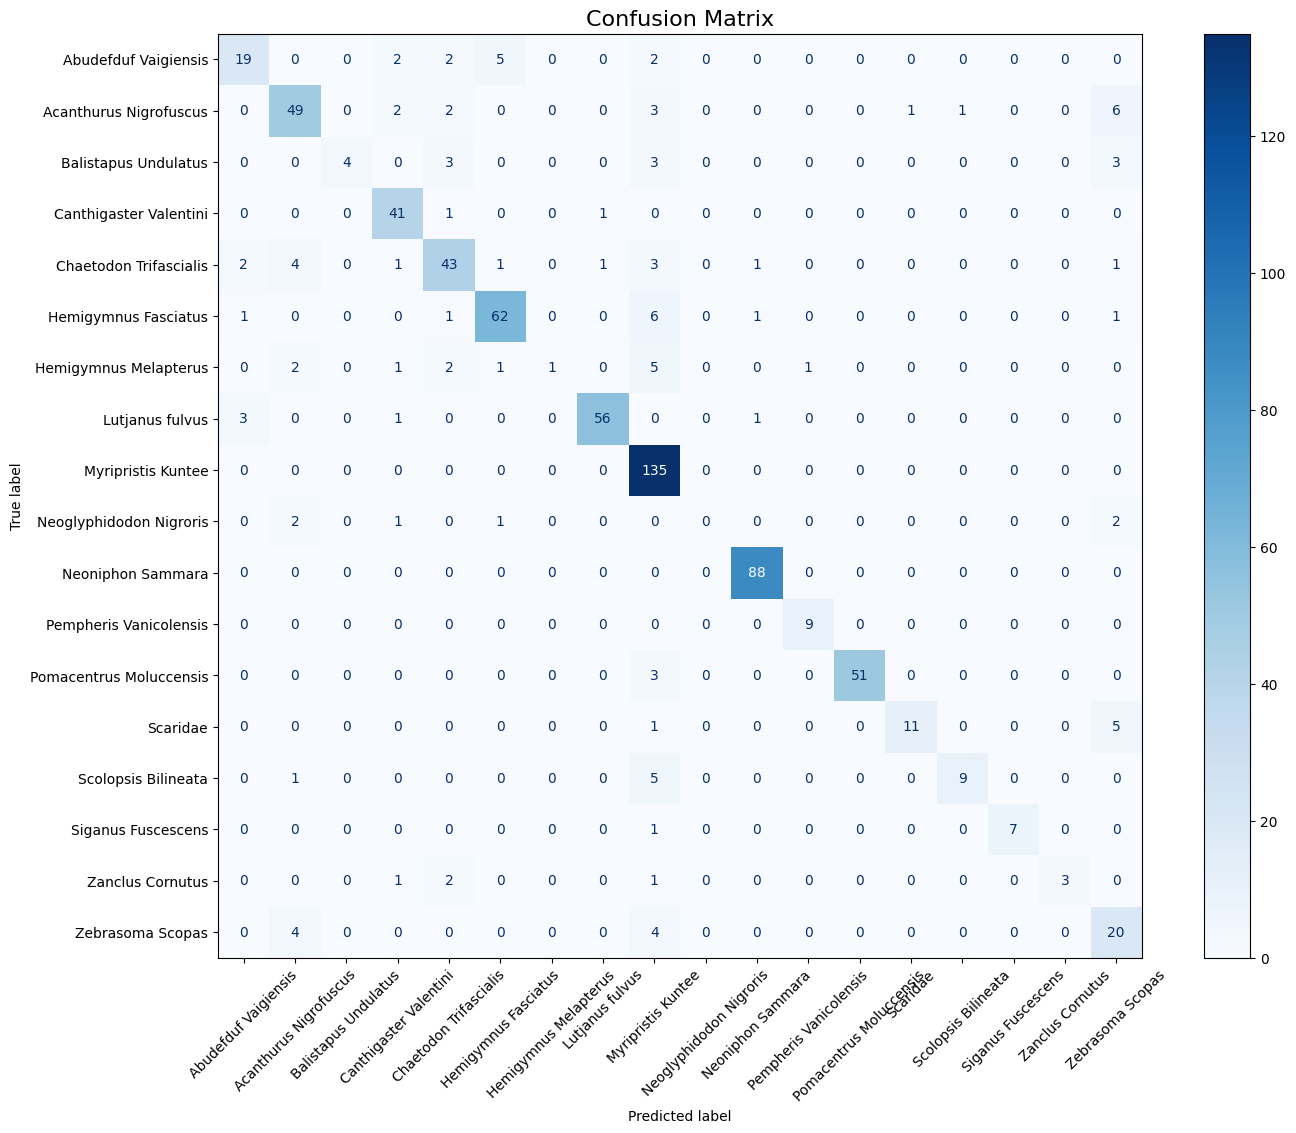

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = [class_names[i] for i in y_true]
y_pred = [class_names[i] for i in y_pred]

cm = confusion_matrix(y_true, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(16, 12))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, ax=plt.gca())

# Customize axis label sizes for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

**PLOT FROM HISTORY**

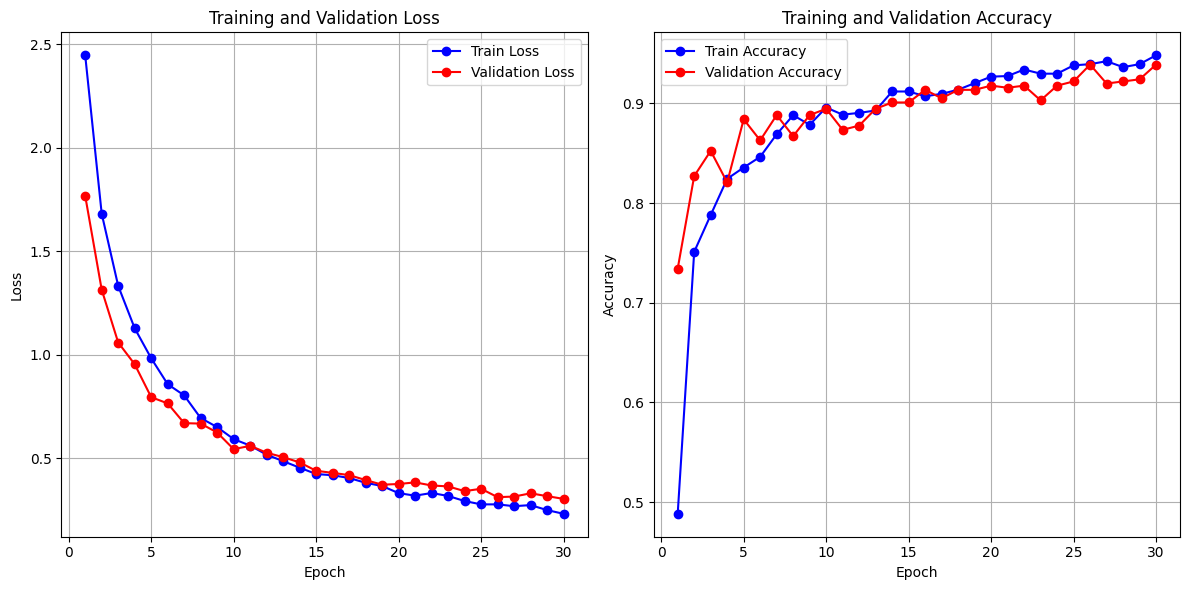

In [113]:
# loaded_history = load_history_from_csv('./saved_models/PREFINAL/history/torch_history_BESTproposedwithUNETmergedlayer4dp5b32notauglr001enhancedvallacc99testacc99-03traintime8m10sepoch5ratio70_30ratioNOBatchNormNOOVERFIT.csv')
# ENHANCED
plot_from_history(baseline_history, max_epochs=30) # use loaded history for csv

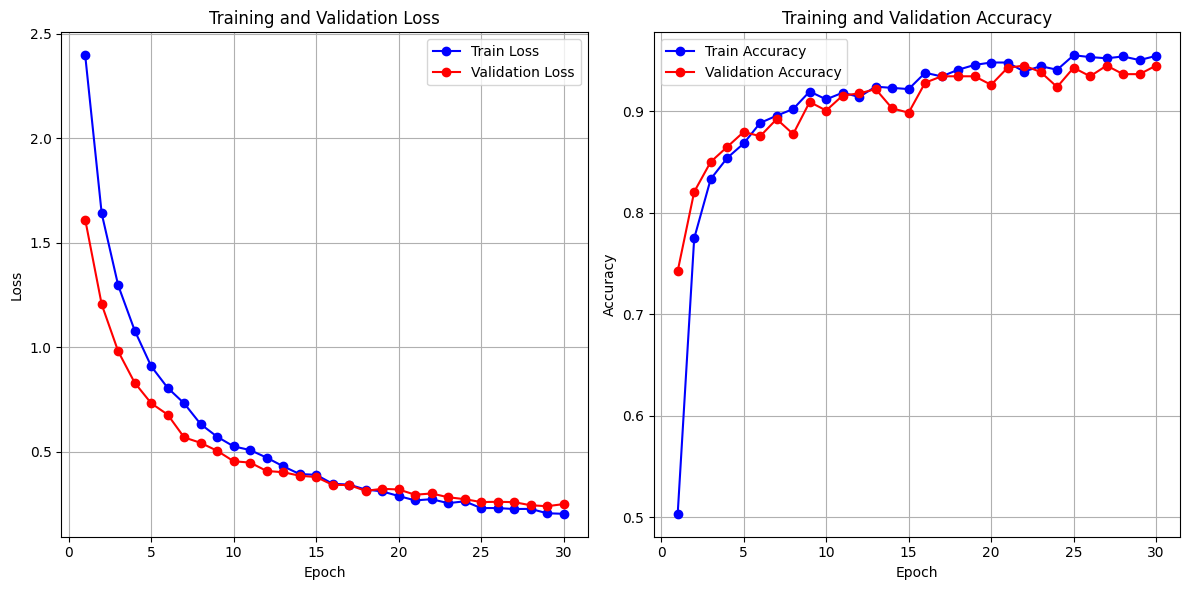

In [106]:
#NOT ENHANCED
plot_from_history(baseline_history, max_epochs=30) # use loaded history for csv

**TEST ON SINGLE IMAGE**

['Abudefduf Vaigiensis', 'Acanthurus Nigrofuscus', 'Balistapus Undulatus', 'Canthigaster Valentini', 'Chaetodon Trifascialis', 'Hemigymnus Fasciatus', 'Hemigymnus Melapterus', 'Lutjanus fulvus', 'Myripristis Kuntee', 'Neoglyphidodon Nigroris', 'Neoniphon Sammara', 'Pempheris Vanicolensis', 'Pomacentrus Moluccensis', 'Scaridae', 'Scolopsis Bilineata', 'Siganus Fuscescens', 'Zanclus Cornutus', 'Zebrasoma Scopas']


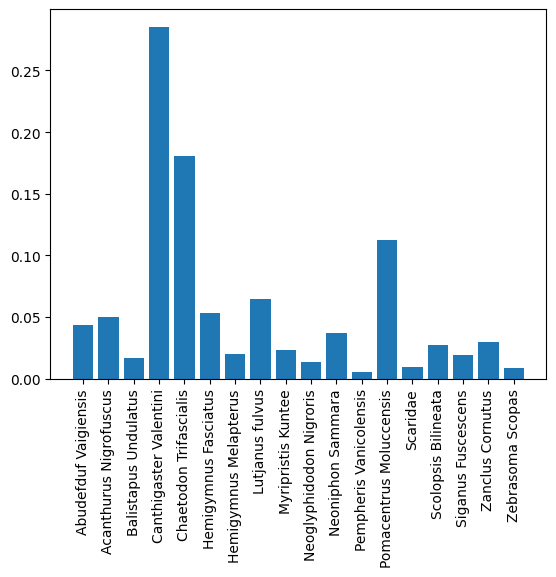

Predicted Class: Canthigaster Valentini
Confidence: 28.55%
Inference Time: 0.3678 seconds


In [ ]:
class_labels = train_dataset.classes
print(class_labels)


image_path = "./TESTS/images/LR/Zanclus Cornutus.png"

random_path = "./DATASET/TEST/Balistapus Undulatus/fish_000021760001_01812.png"
predicted_class, confidence, prediction_time = predict_image_with_debug(torch_baseline_model, image_path, device, class_labels)

print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence * 100:.2f}%") 
print(f"Inference Time: {prediction_time:.4f} seconds")


**Save Model - MAKE FILENAME MEANINGFUL**

In [107]:

df = pd.DataFrame(baseline_history)

# HISTORY OR GRAPH
df.to_csv('./saved_models/history/TEST_torch_history_BASELINEb16freezedAllnotauglr001decay_1e_4_vallacc_testacc_traintime_sepoch30ratio70_30.csv', index=False)

# MODEL
torch.save(torch_baseline_model, './saved_models/model/TEST_torch_BASELINEb16freezedAllnotauglr001decay_1e_4_vallacc_testacc_traintime_sepoch30ratio70_30.pth')

#WEIGHTS
torch.save(torch_baseline_model.state_dict(), './saved_models/weights/TEST_torch_weights_BASELINEb16freezedAllnotauglr001decay_1e_4_vallacc_testacc_traintime_sepoch30ratio70_30.pth')

In [112]:

df = pd.DataFrame(baseline_history)

# HISTORY OR GRAPH
df.to_csv('./saved_models/history/TEST_torch_history_BASELINEwithUNET_ESRGANb16freezedAllnotauglr001decay_1e_4_vallacctest_acc_traintime_sepoch30ratio70_30.csv', index=False)

# MODEL
torch.save(torch_baseline_model, './saved_models/model/TEST_torch_BASELINEwithUNET_ESRGANb16freezedAllnotauglr001decay_1e_4_vallacc_testacc_traintime_sepoch30ratio70_30.pth')

#WEIGHTS
torch.save(torch_baseline_model.state_dict(), './saved_models/weights/TEST_torch_weights_BASELINEwithUNET_ESRGANb16freezedAllnotauglr001decay_1e_4_evallacc_testacc_traintime_sepoch30ratio70_30.pth')

**LOAD MODEL**

In [ ]:
torch_baseline_model = BaselineResNet(torch_baseline).to(device)

torch_baseline_model.load_state_dict(torch.load("./saved_models/model/torch_weights_baselineb16aug1enhancedlr001FreezeAllvallacc86testacc92,11traintime3m10s.pth", map_location=device))

# Set the model to evaluation mode
torch_baseline_model.eval()

# PROPOSED (TENSORFLOW)

In [ ]:
proposed_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in proposed_model.layers[:143]:
    layer.trainable = False


for i, layer in enumerate(proposed_model.layers):
   print(i, layer.name, layer.trainable)


0 input_layer_8 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv

In [ ]:
x = proposed_model.output

proposed_gap = GlobalAveragePooling2D()(x)
proposed_gmp = GlobalMaxPooling2D()(x)

concat = Concatenate()([proposed_gap, proposed_gmp])

x = Dropout(0.5)(concat) 

output_layer = Dense(18, activation="softmax", name='classification_output')(x)

# Final model
proposed_model = Model(inputs=proposed_model.input, outputs=output_layer, name="baseline_ResNet-50")


initial_lr = 0.001

optimizer = Adamax(learning_rate=initial_lr)

proposed_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:

proposed_history_tensorflow = proposed_model.fit(
    enhancedtrain_generator,
    validation_data = enhancedvalidation_generator,
    epochs=5,
    validation_freq=1,
#    class_weight = class_weight_dict,
    verbose=1,
    #callbacks=[reduce_lr]
)



d:\workspace\ThesisProject\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.5850 - loss: 5.6615 - val_accuracy: 0.6603 - val_loss: 4.9159
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9184 - loss: 0.4833 - val_accuracy: 0.8608 - val_loss: 0.8043
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9256 - loss: 0.3993 - val_accuracy: 0.9578 - val_loss: 0.2701
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.9641 - loss: 0.1412 - val_accuracy: 0.9684 - val_loss: 0.1880
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9648 - loss: 0.1488 - val_accuracy: 0.9641 - val_loss: 0.1803


# PROPOSED (PYTORCH)

In [ ]:
learning_rate = 0.001
epochs = 5


torch_proposed = resnet50(weights="IMAGENET1K_V1")
torch_proposed = torch_proposed.to(device)


# freeze = True
# for name, layer in torch_proposed.named_modules():
#     # Explicitly freeze all layers up to layer3
#     if 'layer4' in name:
#         freeze = False  # Start unfreezing at layer3
#     if freeze:
#         for param in layer.parameters():
#             param.requires_grad = False
#     else:
#         for param in layer.parameters():
#             param.requires_grad = True

# FREEZE ALL LAYERS
for param in torch_proposed.parameters():
    param.requires_grad = False

for param in torch_proposed.fc.parameters():
    param.requires_grad = True


class ProposedResNet(nn.Module):
    def __init__(self, base_model, num_classes=18, dropout_rate=0.5):
        super(ProposedResNet, self).__init__()
        self.base_model = nn.Sequential(*list(base_model.children())[:-2])  # Exclude top layers
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.gmp = nn.AdaptiveMaxPool2d((1, 1))
        # self.bn = nn.BatchNorm1d(4096)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(4096, num_classes)  # 4096 (2048 from GAP + 2048 from GMP)

    def forward(self, x):
        x = self.base_model(x)

        gap = self.gap(x).view(x.size(0), -1)
        gmp = self.gmp(x).view(x.size(0), -1)
        x = torch.cat((gap, gmp), dim=1)
        # x = torch.tanh(x)  
        # x = self.bn(x)
        x = self.dropout(x)
        x = self.fc(x)

        return x


torch_proposed_model = ProposedResNet(torch_proposed).to(device)

learning_rate = .001
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adamax(torch_proposed_model.parameters(), lr=0.001)



for name, layer in torch_proposed_model.named_modules():
    print(f'{name}: {any(param.requires_grad for param in layer.parameters())}')


: True
base_model: True
base_model.0: False
base_model.1: False
base_model.2: False
base_model.3: False
base_model.4: False
base_model.4.0: False
base_model.4.0.conv1: False
base_model.4.0.bn1: False
base_model.4.0.conv2: False
base_model.4.0.bn2: False
base_model.4.0.conv3: False
base_model.4.0.bn3: False
base_model.4.0.relu: False
base_model.4.0.downsample: False
base_model.4.0.downsample.0: False
base_model.4.0.downsample.1: False
base_model.4.1: False
base_model.4.1.conv1: False
base_model.4.1.bn1: False
base_model.4.1.conv2: False
base_model.4.1.bn2: False
base_model.4.1.conv3: False
base_model.4.1.bn3: False
base_model.4.1.relu: False
base_model.4.2: False
base_model.4.2.conv1: False
base_model.4.2.bn1: False
base_model.4.2.conv2: False
base_model.4.2.bn2: False
base_model.4.2.conv3: False
base_model.4.2.bn3: False
base_model.4.2.relu: False
base_model.5: False
base_model.5.0: False
base_model.5.0.conv1: False
base_model.5.0.bn1: False
base_model.5.0.conv2: False
base_model.5.0.b

**TRAIN METHOD 1**

In [ ]:
# Train model
proposed_history = train_model(torch_proposed_model, enhanced_train_loader, enhanced_test_loader, optimizer, criterion, epochs=epochs, device=device)

**TRAIN METHOD 2**

In [68]:
# Train model
proposed_history = train_and_validate(torch_proposed_model, criterion, optimizer, enhanced_train_loader, enhanced_test_loader, device, num_epochs=5)

=====================================Epoch: 1=====================================


[VALID] : 100%|██████████| 45/45 [00:20<00:00,  2.21it/s]


=> Train Loss=1.4330, Val Loss=0.5717 |  Train Acc=0.6772,  Val Acc=0.8542
=====================================Epoch: 2=====================================


[VALID] : 100%|██████████| 45/45 [00:20<00:00,  2.20it/s]


=> Train Loss=0.5854, Val Loss=0.4016 |  Train Acc=0.8553,  Val Acc=0.8972
=====================================Epoch: 3=====================================


[VALID] : 100%|██████████| 45/45 [00:17<00:00,  2.55it/s]


=> Train Loss=0.4106, Val Loss=0.3436 |  Train Acc=0.8928,  Val Acc=0.9111
=====================================Epoch: 4=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.27it/s]


=> Train Loss=0.3241, Val Loss=0.3101 |  Train Acc=0.9136,  Val Acc=0.9208
=====================================Epoch: 5=====================================


[VALID] : 100%|██████████| 45/45 [00:16<00:00,  2.77it/s]

=> Train Loss=0.2403, Val Loss=0.2673 |  Train Acc=0.9327,  Val Acc=0.9250


# PROPOSED 2 (PYTORCH)

In [ ]:
# Model Definition
torch_proposed2_model = models.resnet50(weights="IMAGENET1K_V1")
torch_proposed2_model.avgpool = nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.AdaptiveMaxPool2d((1, 1))
)

torch_proposed2_model.fc = nn.Sequential(
    nn.BatchNorm1d(4096),
    nn.Dropout(0.5),
    nn.Linear(4096, 18)
)


# Freeze all layers
freeze = False
for name, param in torch_proposed2_model.named_parameters():
    if name.startswith("fc") or freeze:
        param.requires_grad = True  
        freeze = True
    else:
        param.requires_grad = False  


torch_proposed2_model = torch_proposed2_model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(torch_proposed2_model.parameters(), lr=0.001)

for name, layer in torch_proposed2_model.named_modules():
    print(f'{name}: {any(param.requires_grad for param in layer.parameters())}')
    


In [ ]:
proposed2_history = train_and_validate(torch_proposed2_model, criterion, optimizer, train_loader, test_loader, device, num_epochs=5)


# TEST PROPOSED

**CLASSIFICATION REPORT**

In [23]:

# Test model and evaluate performance
y_true, y_pred = test_model(torch_proposed_model, enhanced_test_loader)

print("\nClassification Report:")
class_names = train_dataset.classes

print(classification_report(y_true, y_pred, target_names=class_names))

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'\nF1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Classification Report:
                         precision    recall  f1-score   support

   Abudefduf Vaigiensis       0.97      1.00      0.98        30
 Acanthurus Nigrofuscus       0.97      1.00      0.98        64
   Balistapus Undulatus       0.87      1.00      0.93        13
 Canthigaster Valentini       1.00      1.00      1.00        43
 Chaetodon Trifascialis       0.98      1.00      0.99        57
   Hemigymnus Fasciatus       1.00      0.97      0.99        72
  Hemigymnus Melapterus       1.00      0.85      0.92        13
        Lutjanus fulvus       1.00      0.97      0.98        61
     Myripristis Kuntee       1.00      1.00      1.00       135
Neoglyphidodon Nigroris       1.00      0.83      0.91         6
      Neoniphon Sammara       1.00      1.00      1.00        88
 Pempheris Vanicolensis       1.00      1.00      1.00         9
Pomacentrus Moluccensis       1.00      1.00      1.00        54
               Scaridae       1.00      1.00      1.00        17


**PLOT FROM HISTORY**

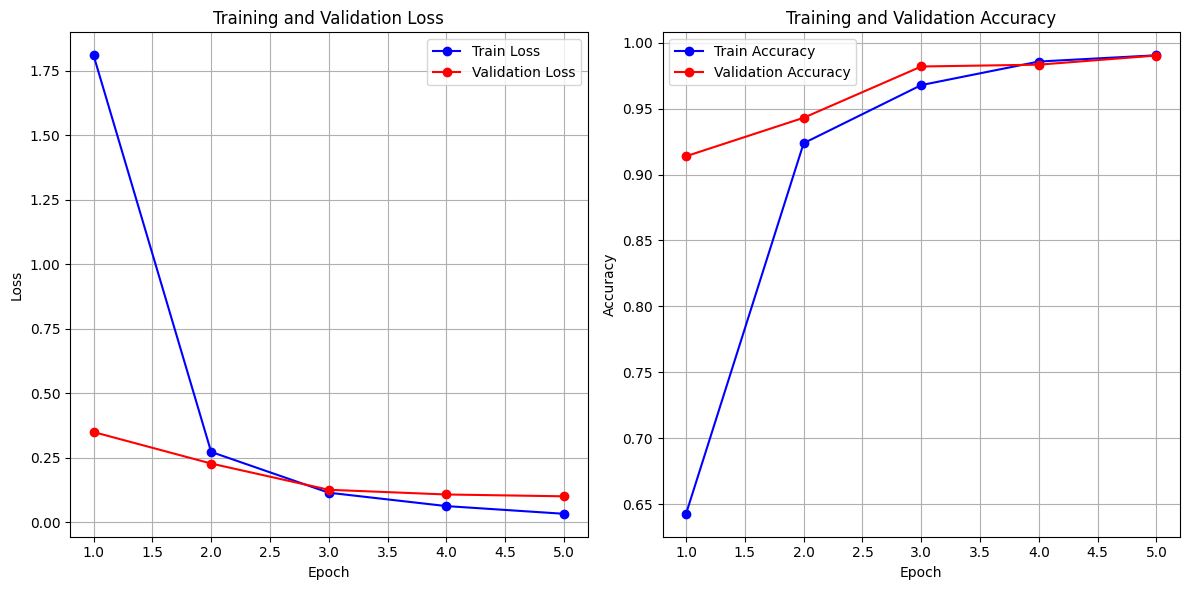

In [29]:
loaded_history = load_history_from_csv('./saved_models/PREFINAL/history/torch_history_BESTproposedwithUNETmergedlayer4dp5b32notauglr001enhancedvallacc99testacc99-03traintime8m10sepoch5ratio70_30ratioNOBatchNormNOOVERFIT.csv')
plot_from_history(loaded_history, max_epochs=5)

**TEST ON SAMPLE IMAGE**

In [ ]:
class_labels = train_dataset.classes
print(class_labels)


image_path = "./DATASET/TEST_ESRGAN_UNET/Balistapus Undulatus/fish_000021760001_01817.png"

random_path = './TESTS/images/LR/Balistapus Undulatus-notenhanced.png'
predicted_class, confidence, prediction_time = predict_image_with_debug(torch_proposed_model, image_path, device, class_labels)

predicted_class_label = predicted_class


print(f"Predicted Class: {predicted_class_label}")
print(f"Confidence: {confidence * 100:.2f}%") 
print(f"Inference Time: {prediction_time:.4f} seconds")


**SAVE MODEL: MAKE FILENAME MEANINGFUL**

In [ ]:

df = pd.DataFrame(proposed_history)
# HISTORY OR GRAPH
df.to_csv('./saved_models/PREFINAL/history/torch_history_FINALproposedwithUNETdp2b32notauglr001enhancedESRGAN2vallacc99_31testacc99_31traintime4m21sepoch5ratio70_30NOBatchNormSlightOVERFIT.csv', index=False)

# MODEL
torch.save(torch_proposed_model, './saved_models/PREFINAL/model/torch_FINALproposedwithUNETdp2b32notauglr001enhancedESRGAN2vallacc99_31testacc99_31traintime4m21sepoch5ratio70_30NOBatchNormSlightOVERFIT.pth')

# WEIGHTS
torch.save(torch_proposed_model.state_dict(), './saved_models/PREFINAL/weights/torch_weights_FINALproposedwithUNETdp2b32notauglr001enhancedESRGAN2vallacc99_31testacc99_31traintime4m21sepoch5ratio70_30NOBatchNormSlightOVERFIT.pth')

**LOAD MODEL**

In [28]:
torch_proposed_model = ProposedResNet(torch_proposed).to(device)

torch_proposed_model.load_state_dict(torch.load("./saved_models/PREFINAL/weights/torch_weights_BESTproposedwithUNETmergedlayer4dp5b32notauglr001enhancedvallacc99testacc99-03traintime8m10sepoch5ratio70_30ratioNOBatchNormNOOVERFIT.pth", map_location=device))

# Set the model to evaluation mode
torch_proposed_model.eval()

ProposedResNet(
  (base_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): C

# OTHER MODELS

**VGG016**

In [ ]:
# Model Definition
from torchvision.models import vgg16
torch.cuda.empty_cache()

torch_vgg_model = vgg16(weights="IMAGENET1K_V1")

# Modify the classifier to match the number of classes
torch_vgg_model.classifier[6] = nn.Linear(4096, 18)

# Freeze all layers except the classifier
for param in torch_vgg_model.features.parameters():
    param.requires_grad = False

# for name, param in torch_vgg_model.named_parameters():
#     print(f"Parameter: {name}, Trainable: {param.requires_grad}")

torch_vgg_model = torch_vgg_model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(filter(lambda p: p.requires_grad, torch_vgg_model.parameters()), lr=0.001)


# Train the model
vgg_history = train_and_validate(torch_vgg_model, criterion, optimizer, train_loader, test_loader, device, num_epochs=5)


**INCEPTION**

In [ ]:
# Model Definition
from torchvision.models import inception_v3 
torch.cuda.empty_cache()
torch_inception_model = inception_v3(weights="IMAGENET1K_V1")

# Modify the classifier to match the number of classes
torch_inception_model.fc = nn.Linear(torch_inception_model.fc.in_features, 18)

# Freeze all layers except the classifier
for param in torch_inception_model.parameters():
    param.requires_grad = False

for param in torch_inception_model.fc.parameters():
    param.requires_grad = True

torch_inception_model = torch_inception_model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(torch_inception_model.fc.parameters(), lr=0.001)

# Train the model
inception_history = train_and_validate(torch_inception_model, criterion, optimizer, train_loader, test_loader, device, num_epochs=5)


**Dense Net**

In [ ]:
# Model Definition
torch_densenet_model = models.densenet121(weights="IMAGENET1K_V1")

# Modify the classifier to match the number of classes
num_features = torch_densenet_model.classifier.in_features


# Freeze all layers except the classifier
for param in torch_densenet_model.features.parameters():
    param.requires_grad = False
# Train the model
torch_densenet_model.classifier = nn.Linear(num_features, 18)

optimizer = optim.Adamax(torch_densenet_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
# Loss function and optimizer

torch_densenet_model = torch_densenet_model.to(device)

densenet_history = train_and_validate(torch_densenet_model, criterion, optimizer, train_loader, test_loader, device, num_epochs=5)




# TRAIN TEST SPLIT DO NOT RUN

In [ ]:
import os
import shutil
import random

# Paths to your dataset folders


# Desired split ratio
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

finished_folders = ['Acanthurus Nigrofuscus', 'Canthigaster Valentini', 'Chaetodon Trifascialis',
                    'Hemigymnus Fasciatus', 'Neoniphon Sammara', 'Pomacentrus Moluccensis',
                    'Myripristis Kuntee', 'Lutjanus fulvus'] 

skip_classes = ['class_to_skip_1', 'class_to_skip_2']

# Create Validation and Test subdirectories with class subfolders
def create_folders(src_dir, dest_dir):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    for class_folder in os.listdir(src_dir):
        if class_folder in finished_folders:
            continue
   
        class_path = os.path.join(dest_dir, class_folder)
        if not os.path.exists(class_path):
            os.makedirs(class_path)

create_folders(train_dir, validation_dir)
create_folders(train_dir, test_dir)

# Function to split data
def split_data(src_dir, val_dir, test_dir, train_ratio, val_ratio, test_ratio):
    for class_folder in os.listdir(src_dir):
        if class_folder in finished_folders:
            continue

        class_path = os.path.join(src_dir, class_folder)
        images = os.listdir(class_path)
        random.shuffle(images)

        # Calculate the split index
        total_images = len(images)
        train_count = int(total_images * train_ratio)
        val_count = int(total_images * val_ratio)
        
        # Split images into train, val, test
        train_images = images[:train_count]
        val_images = images[train_count:train_count + val_count]
        test_images = images[train_count + val_count:]
        
        # Move validation images
        for image in val_images:
            src_image_path = os.path.join(class_path, image)
            dest_image_path = os.path.join(val_dir, class_folder, image)
            shutil.move(src_image_path, dest_image_path)
        
        # Move test images
        for image in test_images:
            src_image_path = os.path.join(class_path, image)
            dest_image_path = os.path.join(test_dir, class_folder, image)
            shutil.move(src_image_path, dest_image_path)

# Split the dataset
split_data(train_dir, validation_dir, test_dir, train_ratio, val_ratio, test_ratio)
